In [3]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(purrr)
library(splines)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [4]:
# 读取并整理数据（你已有前置代码）
all_event_wide_lists_withoutavg_1_8 <- readRDS("all_event_wide_lists_withoutavg_1_8.RDS")
data_list <- all_event_wide_lists_withoutavg_1_8[["SE"]][["Bombyx_mori"]]
meta_cols <- c("GeneID","geneSymbol","chr","strand",
               "exonStart_0base","exonEnd","upstreamES","upstreamEE","downstreamES","downstreamEE")
psi_cols <- setdiff(colnames(data_list), meta_cols)

In [5]:
custom_order <- c(
  "Egg-0_days", "Egg-20-22_hours", "Egg-24_hours", "Egg-1_day", "Egg-2_days", "Egg-36_hours", 
  "Egg-3_days", "Egg-72_hours", "Egg-120_hours", "Egg-168_hours", "Egg-192_hours", "Egg-216_hours", 
  "Larva-0_hours", "Larva-1_day_of_1_instar", "Larva-48_hours", "Larva-96_hours", "Larva-1_instar", 
  "Larva-2_instar", "Larva-0_day_of_3_instar", "Larva-24_hours_of_4_instar", "Larva-1_day_of_4_instar", 
  "Larva-2_day_of_4_instar", "Larva-3_day_of_4_instar", "Larva-4_day_of_4_instar", "Larva-4_instar", 
  "Larva-10_day_of_4_instar", "Larva-11_day_of_4_instar", "Larva-12_day_of_4_instar", "Larva-0_day_of_5_instar", 
  "Larva-1_day_of_5_instar", "Larva-2_day_of_5_instar", "Larva-3_day_of_5_instar", "Larva-4_day_of_5_instar", 
  "Larva-5_instar", "Larva-6_day_of_5_instar", "Larva-7_day_of_5_instar", "Larva-8_day_of_5_instar", 
  "Larva-9_day_of_5_instar", "Larva-10_day_of_5_instar", "Larva-12_day_of_5_instar", "Larva-13_day_of_5_instar", 
  "Larva-14_day_of_5_instar", "Larva-15_day_of_5_instar", "Larva-wandering_stage", "Larva-36h_wandering_stage",
  "Larva-52h_wandering_stage", "Pupa-stage_5", 
  "Adult-0h", "Adult-1_day", "Adult-2_days", "Adult-4_days", "Adult-5_days"
)


In [6]:
data_long_parsed2 <- data_list %>%
  select(all_of(meta_cols), all_of(psi_cols)) %>%
  pivot_longer(
    cols      = all_of(psi_cols),
    names_to  = "Stage_Tissue",
    values_to = "PSI_string"
  ) %>%
  separate_rows(PSI_string, sep = ",") %>%
  mutate(PSI_value = as.numeric(PSI_string)) %>%
  filter(!is.na(PSI_value)) %>%
  group_by(GeneID, Stage_Tissue) %>%
  summarise(PSI_value = mean(PSI_value), .groups="drop") %>%
  separate(
    col  = Stage_Tissue,
    into = c("Stage","Stage_xifen","Tissue"),
    sep  = "__",
    remove = FALSE
  ) %>%
  mutate(
    Stage = if_else(Stage == "Cell", "Egg", Stage),
    Tissue = if_else(Tissue %in% c("Egg","Pupa"), "Whole_body", Tissue),
    Stage = factor(Stage, levels = c("Egg","Larva","Pupa","Adult")),
    Combined_Stage = paste(Stage, Stage_xifen, sep = "-")
  ) %>%
  filter(Combined_Stage %in% custom_order) %>%
  mutate(Combined_Stage = factor(Combined_Stage, levels = custom_order)) %>%
  arrange(Stage, Stage_xifen)


In [7]:
# 提取 Whole_body 作为基准数据
df_whole <- data_long_parsed2 %>%
  filter(Tissue == "Whole_body") %>%
  select(GeneID, Combined_Stage, PSI_whole = PSI_value)

In [8]:
# 构建阶段到时间（小时）的映射（根据前面生成的索引）
time_index_mapping <- c(
  "Egg-0_days" = 2,
  "Egg-20-22_hours" = 21,
  "Egg-24_hours" = 24,
  "Egg-1_day" = 24,
  "Egg-2_days" = 48,
  "Egg-36_hours" = 36,
  "Egg-3_days" = 72,
  "Egg-72_hours" = 72,
  "Egg-120_hours" = 120,
  "Egg-168_hours" = 168,
  "Egg-192_hours" = 192,
  "Egg-216_hours" = 216,
  "Larva-0_hours" = 216,
  "Larva-1_day_of_1_instar" = 240,
  "Larva-48_hours" = 264,
  "Larva-96_hours" = 312,
  "Larva-1_instar" = 312,
  "Larva-2_instar" = 360,
  "Larva-0_day_of_3_instar" = 408,
  "Larva-24_hours_of_4_instar" = 456,
  "Larva-1_day_of_4_instar" = 480,
  "Larva-2_day_of_4_instar" = 504,
  "Larva-3_day_of_4_instar" = 528,
  "Larva-4_day_of_4_instar" = 552,
  "Larva-4_instar" = 552,
  "Larva-10_day_of_4_instar" = 696,
  "Larva-11_day_of_4_instar" = 720,
  "Larva-12_day_of_4_instar" = 744,
  "Larva-0_day_of_5_instar" = 768,
  "Larva-1_day_of_5_instar" = 792,
  "Larva-2_day_of_5_instar" = 816,
  "Larva-3_day_of_5_instar" = 840,
  "Larva-4_day_of_5_instar" = 864,
  "Larva-5_instar" = 864,
  "Larva-6_day_of_5_instar" = 912,
  "Larva-7_day_of_5_instar" = 936,
  "Larva-8_day_of_5_instar" = 960,
  "Larva-9_day_of_5_instar" = 984,
  "Larva-10_day_of_5_instar" = 1008,
  "Larva-12_day_of_5_instar" = 1056,
  "Larva-13_day_of_5_instar" = 1080,
  "Larva-14_day_of_5_instar" = 1104,
  "Larva-15_day_of_5_instar" = 1128,
  "Larva-wandering_stage" = 1152,
  "Larva-36h_wandering_stage" = 1188,
  "Larva-52h_wandering_stage" = 1204,
  "Pupa-stage_5" = 1248,
  "Adult-0h" = 1248,
  "Adult-1_day" = 1272,
  "Adult-2_days" = 1296,
  "Adult-4_days" = 1344,
  "Adult-5_days" = 1368
)

In [9]:
# 将 Combined_Stage 转换为数值时间索引
df_whole <- df_whole %>%
  mutate(time_index = as.numeric(recode(as.character(Combined_Stage), !!!time_index_mapping)))



In [10]:
# ---------------------------
# 转换时间单位及构造自变量：以天为单位，并对天数取对数
# ---------------------------
df_whole <- df_whole %>%
  mutate(day = time_index / 24)  # 将小时转换为天

In [24]:
# ---------------------------
# 针对每个可变剪切事件分别拟合三次样条模型
# 使用对数（天）作为自变量，自由度设为4
# ---------------------------
event_fits <- df_whole %>%
  group_by(GeneID) %>%   # 假定 GeneID 可作为事件的唯一标识；若有其他事件 ID，请替换之
  nest() %>%
  mutate(
    model = map(data, ~ glm(PSI_whole / 1 ~ bs(log(day), df = 4),  # 使用 GLM
                             family = quasibinomial, data = .x)),  
    # 对每个事件在该事件的发育天数范围内生成 1000 个均匀分布的预测点
    newdata = map(data, ~ {
      new_day <- seq(min(.x$day), max(.x$day), length.out = 1000)
      data.frame(day = new_day)
    }),
    PSI_pred = map2(model, newdata, ~ predict(.x, newdata = .y, type = "response"))
  )

Warning message:
“There were 5233 warnings in `mutate()`.
The first warning was:
ℹ In argument: `model = map(...)`.
ℹ In group 12: `GeneID = "AGPAT5"`.
Caused by warning in `bs()`:
! all interior knots match left boundary knot
ℹ Run `dplyr::last_dplyr_warnings()` to see the 5232 remaining warnings.”


In [25]:
# 计算每个事件的 dPSI（预测 PSI 的最大值与最小值之差）
event_fits <- event_fits %>%
  mutate(
    dPSI = map_dbl(PSI_pred, ~ max(.x) - min(.x))
  )


In [26]:
print(event_fits)

# A tibble: 8,642 × 6
# Groups:   GeneID [8,642]
   GeneID     data              model  newdata          PSI_pred        dPSI
   <chr>      <list>            <list> <list>           <list>         <dbl>
 1 14-3-3zeta <tibble [25 × 4]> <glm>  <df [1,000 × 1]> <dbl [1,000]> 0.322 
 2 ACBP       <tibble [24 × 4]> <glm>  <df [1,000 × 1]> <dbl [1,000]> 0.452 
 3 AK         <tibble [20 × 4]> <glm>  <df [1,000 × 1]> <dbl [1,000]> 0.162 
 4 Alg-2      <tibble [18 × 4]> <glm>  <df [1,000 × 1]> <dbl [1,000]> 0.0991
 5 Anxb13     <tibble [25 × 4]> <glm>  <df [1,000 × 1]> <dbl [1,000]> 0.472 
 6 Apaf-1     <tibble [23 × 4]> <glm>  <df [1,000 × 1]> <dbl [1,000]> 0     
 7 Borealin   <tibble [18 × 4]> <glm>  <df [1,000 × 1]> <dbl [1,000]> 0.407 
 8 CDC2L1     <tibble [25 × 4]> <glm>  <df [1,000 × 1]> <dbl [1,000]> 0.790 
 9 CDK2       <tibble [18 × 4]> <glm>  <df [1,000 × 1]> <dbl [1,000]> 0.180 
10 CHD1       <tibble [8 × 4]>  <glm>  <df [1,000 × 1]> <dbl [1,000]> 0.945 
# ℹ 8,632 more rows


In [31]:
# 示例：绘制某个特定事件（GeneID）的拟合结果
selected_event <- "ACBP"  # 请替换为你感兴趣的事件ID
df_plot <- df_whole %>% filter(GeneID == selected_event)
pred_data <- tibble(day = seq(min(df_plot$day), max(df_plot$day), length.out = 1000),
                    PSI_pred = event_fits %>% filter(GeneID == selected_event) %>% pull(PSI_pred) %>% .[[1]])


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'PSI值' in 'mbcsToSbcs': dot substituted for <e5>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'PSI值' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'PSI值' in 'mbcsToSbcs': dot substituted for <bc>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '事件 ACBP 的基于对数(天)自变量的三次样条拟合' in 'mbcsToSbcs': dot substituted for <e4>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '事件 ACBP 的基于对数(天)自变量的三次样条拟合' in 'mbcsToSbcs': dot substituted for <ba>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '事件 ACBP 的基于对数(天)自变量的三次样条拟合' in 'mbcsToSbcs': dot substituted for <8b>”
Warn

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '事件 ACBP 的基于对数(天)自变量的三次样条拟合' in 'mbcsToSbcs': dot substituted for <b7>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '事件 ACBP 的基于对数(天)自变量的三次样条拟合' in 'mbcsToSbcs': dot substituted for <e6>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '事件 ACBP 的基于对数(天)自变量的三次样条拟合' in 'mbcsToSbcs': dot substituted for <9d>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '事件 ACBP 的基于对数(天)自变量的三次样条拟合' in 'mbcsToSbcs': dot substituted for <a1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '事件 ACBP 的基于对数(天)自变量的三次样条拟合' in 'mbcsToSbcs': dot substituted for <e6>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '事件 ACBP 的

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '事件 ACBP 的基于对数(天)自变量的三次样条拟合' in 'mbcsToSbcs': dot substituted for <ba>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '事件 ACBP 的基于对数(天)自变量的三次样条拟合' in 'mbcsToSbcs': dot substituted for <8e>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '事件 ACBP 的基于对数(天)自变量的三次样条拟合' in 'mbcsToSbcs': dot substituted for <e5>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '事件 ACBP 的基于对数(天)自变量的三次样条拟合' in 'mbcsToSbcs': dot substituted for <af>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '事件 ACBP 的基于对数(天)自变量的三次样条拟合' in 'mbcsToSbcs': dot substituted for <b9>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion fai

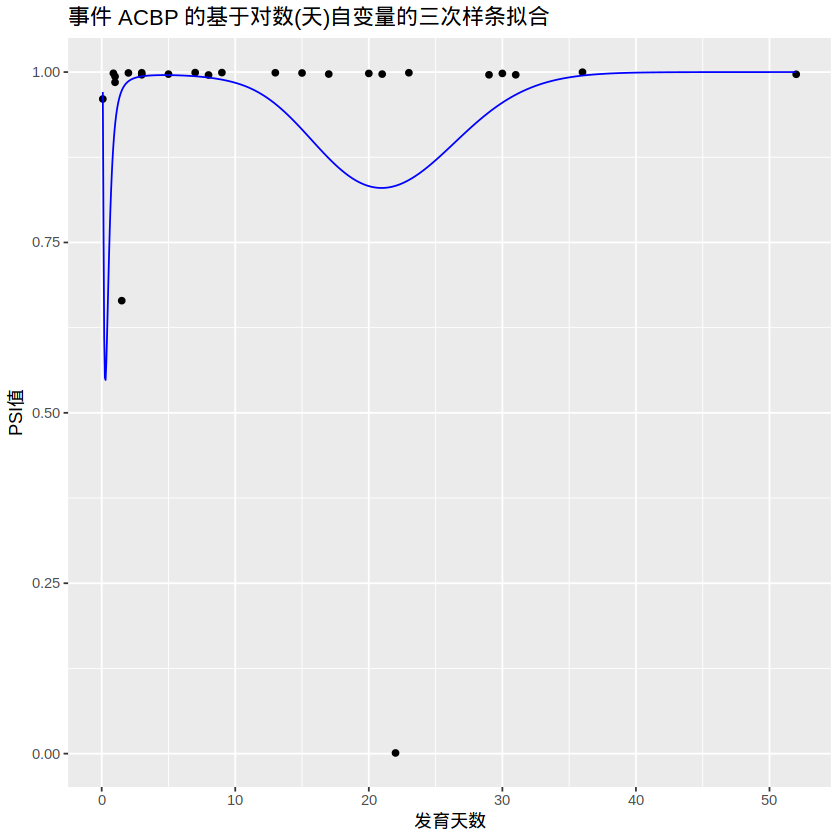

In [32]:
# 绘制拟合结果
p <- ggplot() +
  geom_point(data = df_plot, aes(x = day, y = PSI_whole)) +
  geom_line(data = pred_data, aes(x = day, y = PSI_pred), color = "blue") +
  labs(title = paste("事件", selected_event, "的基于对数(天)自变量的三次样条拟合"),
       x = "发育天数", y = "PSI值")

print(p)